# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-x1r0wfda
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-x1r0wfda
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


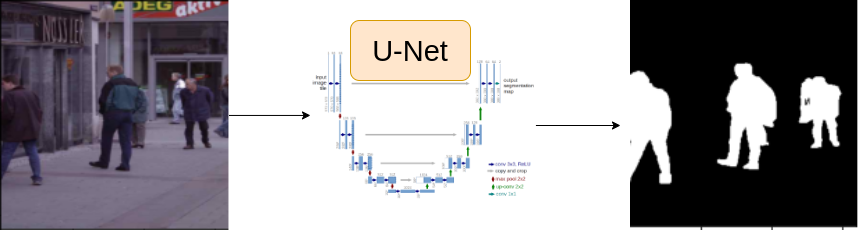

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'
DEVICE='cuda'
EPOCHS=25
LR=0.003
IMAGE_SIZE=320
ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [ ]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[4]
image_path=row.images
mask_path=row.masks


image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0



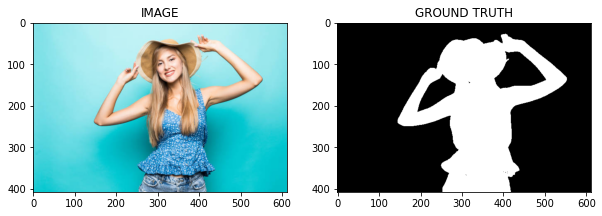

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df= train_test_split(df,test_size=0.2,random_state=42)

In [105]:
len(train_df)+len(valid_df)

290

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)
  ])
def get_valid_augs():
  return A.Compose([A.Resize(IMAGE_SIZE,IMAGE_SIZE)])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset


In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']


    image=np.transpose(image,(2,0,1)).astype(np.float)
    mask=np.transpose(mask,(2,0,1)).astype(np.float)


    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask                    

In [ ]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_valid_augs())

In [106]:
trainset

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


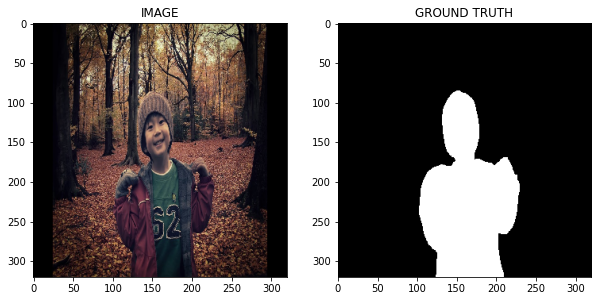

In [ ]:
idx=21
image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
BATCH_SIZE=16
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
for image,mask in trainloader:
  break

print(f"One batch image shape: {mask.shape}")

One batch image shape: torch.Size([16, 1, 320, 320])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self,images,masks=None):
    logits=self.arc(images)

    if masks!= None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1+loss2

    return logits

In [ ]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0

  for images,masks in tqdm(data_loader):

    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()


    total_loss+=loss.item()



  return total_loss/ len(data_loader)
  

In [ ]:
def eval_fn(data_loader,model):
  model.train()
  total_loss=0.0

  with torch.no_grad():

    for images,masks in tqdm(data_loader):

      images=images.to(DEVICE)
      masks=masks.to(DEVICE)


      logits,loss=model(images,masks)


      total_loss+=loss.item()



  return total_loss/ len(data_loader)
  

# Task 8 : Train Model

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)


In [ ]:
best_valid_loss=np.inf
for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(trainloader,model)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("saved-model")
    best_valid_loss=valid_loss


  print(f"Epoch : {i+1} Train_loss: {train_loss} Valid_loss : {valid_loss}")

  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


saved-model
Epoch : 1 Train_loss: 0.41794506708780926 Valid_loss : 0.34914464155832925


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


saved-model
Epoch : 2 Train_loss: 0.3549579481283824 Valid_loss : 0.3160610169172287


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


saved-model
Epoch : 3 Train_loss: 0.25884923835595447 Valid_loss : 0.2794948309659958


100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


saved-model
Epoch : 4 Train_loss: 0.29589603543281556 Valid_loss : 0.24738033612569174


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


saved-model
Epoch : 5 Train_loss: 0.24127328197161357 Valid_loss : 0.21438627938429514


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


saved-model
Epoch : 6 Train_loss: 0.2512360195318858 Valid_loss : 0.20883437395095825


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


saved-model
Epoch : 7 Train_loss: 0.1734858512878418 Valid_loss : 0.16688458869854608


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


Epoch : 8 Train_loss: 0.1942594865957896 Valid_loss : 0.18197202384471894


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


Epoch : 9 Train_loss: 0.1810821940501531 Valid_loss : 0.17302982012430826


100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


saved-model
Epoch : 10 Train_loss: 0.13280968815088273 Valid_loss : 0.12736946046352388


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


Epoch : 11 Train_loss: 0.1429205800096194 Valid_loss : 0.13614369034767151


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


Epoch : 12 Train_loss: 0.17814172158638636 Valid_loss : 0.14861318916082383


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


Epoch : 13 Train_loss: 0.14434892584880193 Valid_loss : 0.13673771719137828


100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


saved-model
Epoch : 14 Train_loss: 0.15506784369548163 Valid_loss : 0.11903675446907679


100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


Epoch : 15 Train_loss: 0.14579566866159438 Valid_loss : 0.12448290785153707


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


Epoch : 16 Train_loss: 0.12360719243685404 Valid_loss : 0.13525835126638414


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


Epoch : 17 Train_loss: 0.15957193871339162 Valid_loss : 0.14180840353171031


100%|██████████| 15/15 [00:03<00:00,  4.30it/s]


Epoch : 18 Train_loss: 0.13528539339701334 Valid_loss : 0.14561415563027064


100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


Epoch : 19 Train_loss: 0.1323036978642146 Valid_loss : 0.1239028458793958


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


saved-model
Epoch : 20 Train_loss: 0.1304558277130127 Valid_loss : 0.11472578446070353


100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


saved-model
Epoch : 21 Train_loss: 0.10810198585192363 Valid_loss : 0.10455978562434515


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


Epoch : 22 Train_loss: 0.11652637720108032 Valid_loss : 0.1146027167638143


100%|██████████| 15/15 [00:03<00:00,  4.26it/s]


Epoch : 23 Train_loss: 0.1563026602069537 Valid_loss : 0.14670951316754025


100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch : 24 Train_loss: 0.15382227698961895 Valid_loss : 0.1263851895928383


100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


saved-model
Epoch : 25 Train_loss: 0.11377362161874771 Valid_loss : 0.09815314610799154


# Task 9 : Inference

In [ ]:
idx=20
model.load_state_dict(torch.load('/content/best_model.pt'))



image,mask=validset[idx]

logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


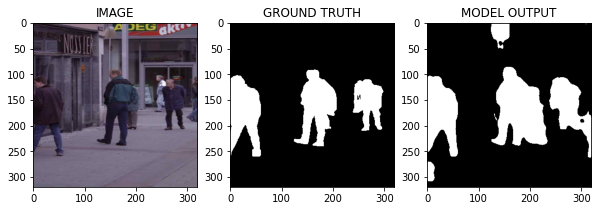

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya